# Sam's Transformer Attempt

### Data Preprocess

In [1]:
import pandas as pd

df = pd.read_csv('./data/unprocessed/tripadvisor_hotel_reviews.csv')

df

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


In [2]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.15, random_state=22)
df_train, df_val = train_test_split(df_train, test_size=0.15/0.85, random_state=23)

df_train.shape, df_val.shape, df_test.shape

((14343, 2), (3074, 2), (3074, 2))

Lemmatize

Tokenize text

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['Review'])

training_sequences = tokenizer.texts_to_sequences(df_train['Review'])

training_sequence_lengths = tuple(len(seq) for seq in training_sequences)

pd.Series(training_sequence_lengths).describe(percentiles=[0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

count    14343.000000
mean       107.703967
std        103.446287
min          8.000000
1%          16.000000
5%          25.000000
10%         32.000000
25%         50.000000
50%         79.000000
75%        128.000000
90%        209.000000
95%        286.000000
99%        516.160000
max       1916.000000
dtype: float64

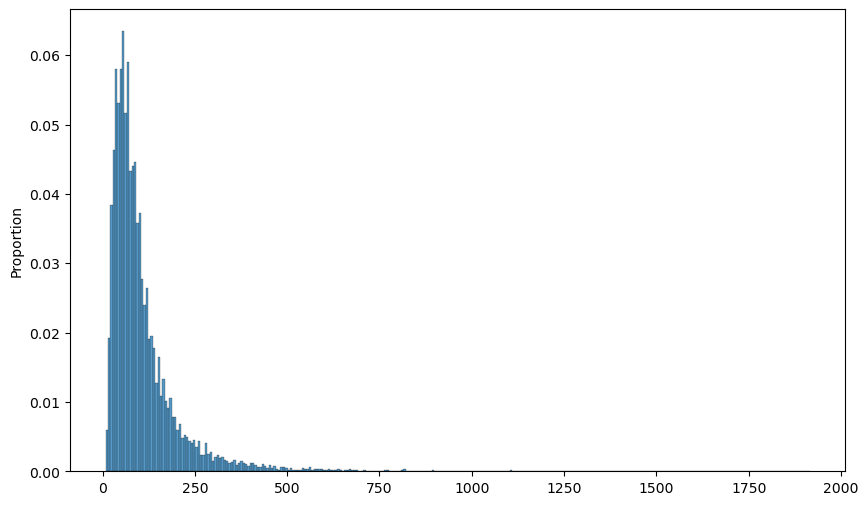

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

sns.histplot(training_sequence_lengths, stat='proportion')

plt.show()

Because roughly 90% of sequences are 200 tokens or less, cut off at 200 tokens

In [5]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(training_sequences, maxlen=200, padding='post')

X_train = X_train.reshape(*X_train.shape, 1)  # reshape for model

X_train.shape

(14343, 200, 1)

Repeat process for validation and testing data

In [6]:
X_val = pad_sequences(tokenizer.texts_to_sequences(df_val['Review']), maxlen=200, padding='post')
X_val = X_val.reshape(*X_val.shape, 1)  # reshape for model

X_test = pad_sequences(tokenizer.texts_to_sequences(df_test['Review']), maxlen=200, padding='post')
X_test = X_test.reshape(*X_test.shape, 1)  # reshape for model

X_val.shape, X_test.shape

((3074, 200, 1), (3074, 200, 1))

Get y variables

In [7]:
y_train = df_train['Rating'].to_numpy()
y_val = df_val['Rating'].to_numpy()
y_test = df_test['Rating'].to_numpy()

y_train.shape, y_val.shape, y_test.shape

((14343,), (3074,), (3074,))

Potential improvements to above:
- Lemmatize
- Possibly remove tokens that do not hit a frequency threshold
- Possibly do some unsupervised analysis to combine similar words into the same tokens

### Model Building

Transformer code: https://www.youtube.com/watch?v=SX67Mni0Or4

In [8]:
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [9]:
from tensorflow.keras import Input, Model

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)*4 + 1 # map to 1-5 stars
    
    return Model(inputs, outputs)

In [97]:
mod = build_model(
    X_train.shape[1:],
    head_size=16,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=1,
    mlp_units=[16],
    mlp_dropout=0.0,
    dropout=0.0,
)

mod.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 200, 1)]     0           []                               
                                                                                                  
 layer_normalization_8 (LayerNo  (None, 200, 1)      2           ['input_5[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 multi_head_attention_4 (MultiH  (None, 200, 1)      449         ['layer_normalization_8[0][0]',  
 eadAttention)                                                    'layer_normalization_8[0][0]']  
                                                                                            

In [98]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

mod.compile(
    loss='mean_squared_error',
    optimizer=Adam(learning_rate=1e-2)
)

mod.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=1024,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
)

Epoch 1/100
15/15 [==============================] - 16s 979ms/step - loss: 2.2963 - val_loss: 2.8878
Epoch 2/100
15/15 [==============================] - 14s 919ms/step - loss: 1.5700 - val_loss: 1.8229
Epoch 3/100
15/15 [==============================] - 14s 914ms/step - loss: 1.4510 - val_loss: 1.6954
Epoch 4/100
15/15 [==============================] - 14s 958ms/step - loss: 1.4377 - val_loss: 1.6662
Epoch 5/100
15/15 [==============================] - 14s 965ms/step - loss: 1.4293 - val_loss: 1.6332
Epoch 6/100
15/15 [==============================] - 15s 978ms/step - loss: 1.4161 - val_loss: 1.6040
Epoch 7/100
15/15 [==============================] - 14s 967ms/step - loss: 1.3951 - val_loss: 1.6037
Epoch 8/100
15/15 [==============================] - 15s 975ms/step - loss: 1.3898 - val_loss: 1.6216
Epoch 9/100
15/15 [==============================] - 15s 976ms/step - loss: 1.3790 - val_loss: 1.6033
Epoch 10/100
15/15 [==============================] - 15s 984ms/step - loss: 1.366

### Model Testing

In [99]:
y_pred = mod.predict(X_test).reshape(-1)

y_pred

97/97 [==============================] - 2s 16ms/step


array([4.177    , 3.217996 , 3.6328435, ..., 4.116725 , 3.8195057,
       2.8272817], dtype=float32)

In [100]:
y_test

array([5, 3, 3, ..., 4, 5, 2], dtype=int64)

In [101]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print(
    f"MAE  : {mean_absolute_error(y_test, y_pred):.2f}\n"
    f"RMSE : {mean_squared_error(y_test, y_pred, squared=False):.2f}\n"
    f"MSE  : {mean_squared_error(y_test, y_pred, squared=True):.2f}"
)

MAE  : 1.00
RMSE : 1.26
MSE  : 1.58


In [72]:
" ".join([tokenizer.index_word.get(X_test[2, i, 0], None) for i in range(100)])

'just ok hi just returned week breezes punta cana like say disappointed 2 couples 30 5th trip dominican republic grounds hotel needs refreshed getting old shows rooms got gave room building 2 casino door theatre loud think worst room humid old matress no boxspring smelled day asked room 3 hours got room building 2 floor ocean view cathedrale ceiling bigger time rained room day asked room finally got bulding 6 refreshed year time bigger tv king size bed noisy pool looked larger magazines difficult chairs pool people leave towels chairs day 3 beach beautiful white sand lot waves strong water'

In [102]:
mock_reviews = pd.Series(
    [
        'I hated the hotel. My experience was terrible. Do not go here.',
        'I loved the hotel. My experience was fantastic. I highly recommend.',
    ]
)

mock_reviews

0    I hated the hotel. My experience was terrible....
1    I loved the hotel. My experience was fantastic...
dtype: object

In [103]:
X_mock = pad_sequences(tokenizer.texts_to_sequences(mock_reviews), maxlen=200, padding='post')
X_mock = X_mock.reshape(*X_mock.shape, 1)  # reshape for model

X_mock.shape

(2, 200, 1)

In [104]:
mod.predict(X_mock)

1/1 [==============================] - 0s 21ms/step


array([[4.1518345],
       [4.171529 ]], dtype=float32)

In [105]:
pd.Series(y_pred).describe(percentiles=[0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

count    3074.000000
mean        3.878533
std         0.346886
min         1.376381
1%          2.633896
5%          3.165569
10%         3.435133
25%         3.768546
50%         3.970302
75%         4.092740
90%         4.163221
95%         4.221927
99%         4.429002
max         4.847025
dtype: float64

In [106]:
df_test['Rating'].describe(percentiles=[0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

count    3074.000000
mean        3.931034
std         1.251797
min         1.000000
1%          1.000000
5%          1.000000
10%         2.000000
25%         3.000000
50%         4.000000
75%         5.000000
90%         5.000000
95%         5.000000
99%         5.000000
max         5.000000
Name: Rating, dtype: float64